In [6]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
from sklearn.manifold import TSNE

os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['HIP_VISIBLE_DEVICES'] = '0'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
train_set = MNIST("../datasets", train=True, download=True, transform=transforms.ToTensor())
test_set = MNIST("../datasets", train=False, download=True, transform=transforms.ToTensor())
train_set.data.shape, test_set.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

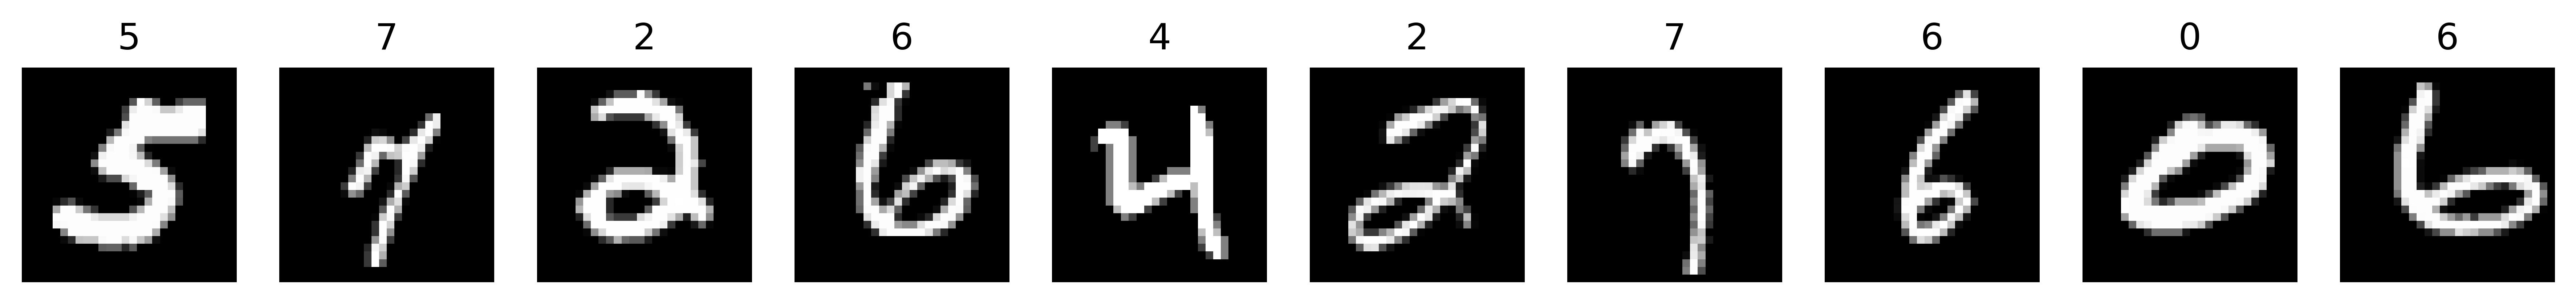

In [4]:
fig, axis = plt.subplots(1, 10, figsize=(15, 5), dpi=600)

for ax in axis:
    idx = np.random.randint(0, len(train_set))
    img = train_set.data[idx]
    label = train_set.targets[idx]
    ax.imshow(img, cmap="gray")
    ax.set_title(label.item())
    ax.axis("off")

plt.show()

In [5]:
BATCH_SIZE = 32
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=True)

In [7]:
class VQVAE(nn.Module):
    def __init__(self) -> None:
        super(VQVAE, self).__init__()

        # encoder part
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, 
                      kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, 
                      kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, stride=2),
        )

        # VQ part
        self.embedding = nn.Embedding(num_embeddings=256, embedding_dim=64)
        self.beta = 0.20

        # decoder part
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, 
                               kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, 
                               kernel_size=3, padding=1, 
                               output_padding=1, stride=2),
            nn.BatchNorm2d(num_features=16),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, 
                               kernel_size=3, padding=1, 
                               output_padding=1, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        
        # print(x.shape) #[batch_size, 64, 3, 3]
        
        B, C, H, W = x.shape

        # B, C, H, W -> B, H, W, C
        x = x.permute(0, 2, 3, 1).contiguous().reshape(B, H * W, -1)
        # print(x.shape)  # [batch_size * 3 * 3, 64]
        
        distances = torch.cdist(
            x, self.embedding.weight.unsqueeze(0).repeat(x.shape[0], 1, 1)) # B, H * W (calculating distance for every pixel)
        # print(distances.shape) # B, 9, 256

        min_distance_idx = torch.argmin(distances, dim=-1)
        # print(min_distance_idx.shape) # B, 9
        
        quantized = torch.index_select(self.embedding.weight, dim=0, index=min_distance_idx.view(-1)) # B * H * W
        # print(quantized.shape) # B * 9, 64

        x = x.reshape(B * H * W, C)

        # x is the encoder output
        codebook_loss = torch.mean((x.detach() - quantized) ** 2)
        commitment_loss = torch.mean((x - quantized.detach()) ** 2)
        
        loss = codebook_loss + self.beta * commitment_loss

        # straight through gradient
        quantized = x + (quantized - x).detach()
        quantized = quantized.reshape(B, H, W, C).permute(0, 3, 1, 2)

        # passing through decoder
        out = self.decoder(quantized)
        return out, quantized, loss

In [8]:
model = VQVAE().to(device)
model.load_state_dict(torch.load("./best_model.pth", weights_only=True, map_location="cpu"))

<All keys matched successfully>

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
optimizer.load_state_dict(torch.load("./optimizer_states.pth", weights_only=True))

In [12]:
NUM_EPOCH = 20
train_loss = []
min_loss = float('inf')

for epoch in range(NUM_EPOCH):

    total_loss = 0
    for input, label in tqdm(train_loader):
        input, label = input.to(device), label.to(device)
        out, quantized_loss = model(input)

        optimizer.zero_grad()
        loss = criterion(out, input)
        loss += quantized_loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    epoch_loss = total_loss / BATCH_SIZE
    train_loss.append(epoch_loss)
    print(f'Epoch: {epoch + 1} | Loss: {epoch_loss:.4f}')

    if epoch_loss < min_loss:
        min_loss = epoch_loss
        torch.save(model.state_dict(), "./best_model.pth")
        torch.save(optimizer.state_dict(), "./optimizer_states.pth")

100%|██████████| 1875/1875 [00:21<00:00, 87.12it/s]


Epoch: 1 | Loss: 19.5149


100%|██████████| 1875/1875 [00:21<00:00, 88.80it/s]


Epoch: 2 | Loss: 19.6116


100%|██████████| 1875/1875 [00:21<00:00, 87.61it/s]


Epoch: 3 | Loss: 19.6096


100%|██████████| 1875/1875 [00:21<00:00, 88.91it/s]


Epoch: 4 | Loss: 19.5854


100%|██████████| 1875/1875 [00:21<00:00, 88.16it/s]


Epoch: 5 | Loss: 19.7068


100%|██████████| 1875/1875 [00:21<00:00, 87.72it/s]


Epoch: 6 | Loss: 19.8328


100%|██████████| 1875/1875 [00:21<00:00, 88.69it/s]


Epoch: 7 | Loss: 19.9063


100%|██████████| 1875/1875 [00:21<00:00, 88.22it/s]


Epoch: 8 | Loss: 19.9982


100%|██████████| 1875/1875 [00:21<00:00, 86.72it/s]


Epoch: 9 | Loss: 20.1514


100%|██████████| 1875/1875 [00:21<00:00, 88.81it/s]


Epoch: 10 | Loss: 20.4699


100%|██████████| 1875/1875 [00:21<00:00, 88.87it/s]


Epoch: 11 | Loss: 20.5630


100%|██████████| 1875/1875 [00:21<00:00, 87.92it/s]


Epoch: 12 | Loss: 20.6903


100%|██████████| 1875/1875 [00:21<00:00, 88.96it/s]


Epoch: 13 | Loss: 20.9576


100%|██████████| 1875/1875 [00:21<00:00, 87.95it/s]


Epoch: 14 | Loss: 21.0359


100%|██████████| 1875/1875 [00:21<00:00, 89.02it/s]


Epoch: 15 | Loss: 21.1569


100%|██████████| 1875/1875 [00:21<00:00, 89.01it/s]


Epoch: 16 | Loss: 21.1289


100%|██████████| 1875/1875 [00:21<00:00, 88.57it/s]


Epoch: 17 | Loss: 21.1360


100%|██████████| 1875/1875 [00:21<00:00, 87.96it/s]


Epoch: 18 | Loss: 21.0816


100%|██████████| 1875/1875 [00:21<00:00, 87.93it/s]


Epoch: 19 | Loss: 20.9813


100%|██████████| 1875/1875 [00:21<00:00, 88.73it/s]

Epoch: 20 | Loss: 20.9692


In [10]:
model.load_state_dict(torch.load("./best_model.pth", weights_only=True, map_location=device))

<All keys matched successfully>

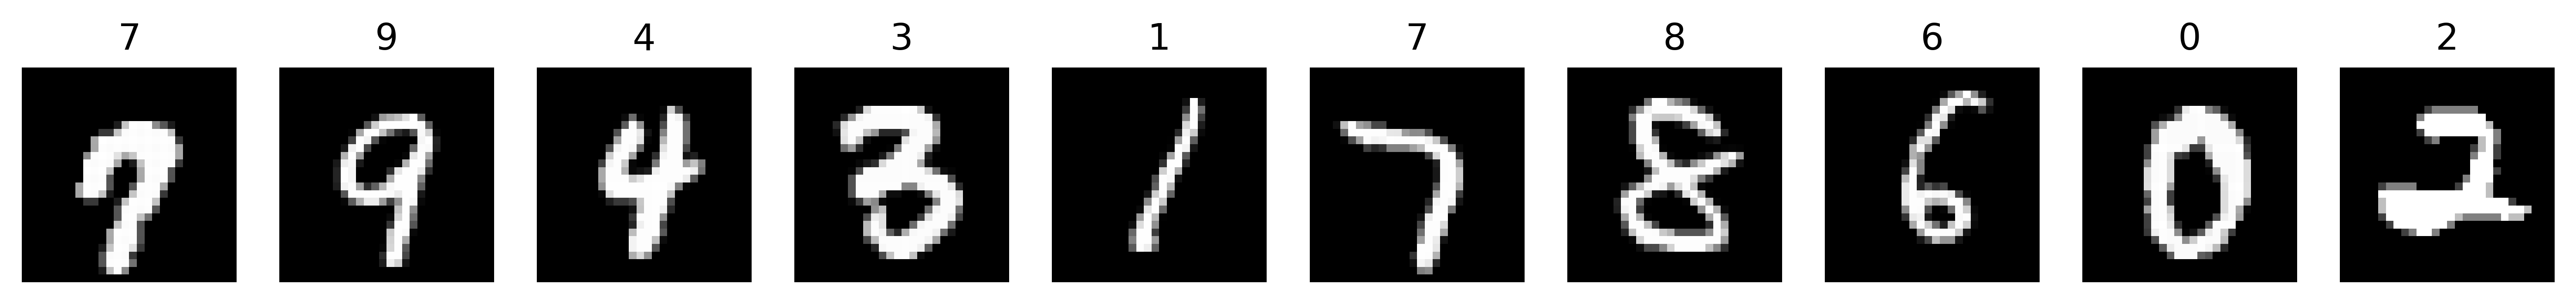

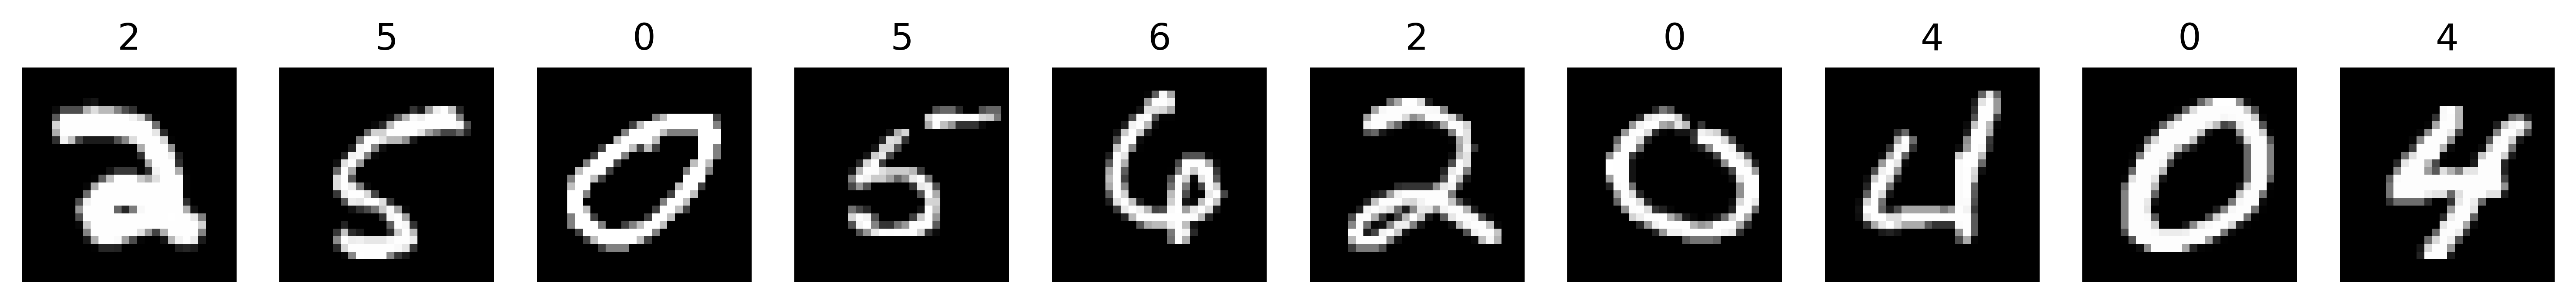

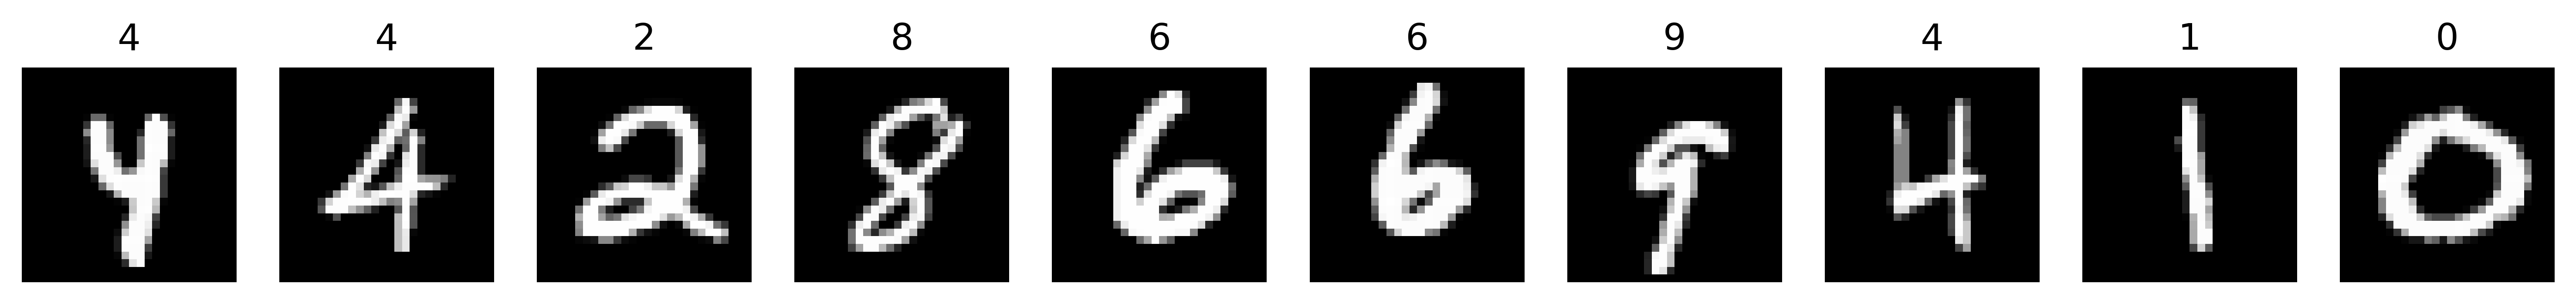

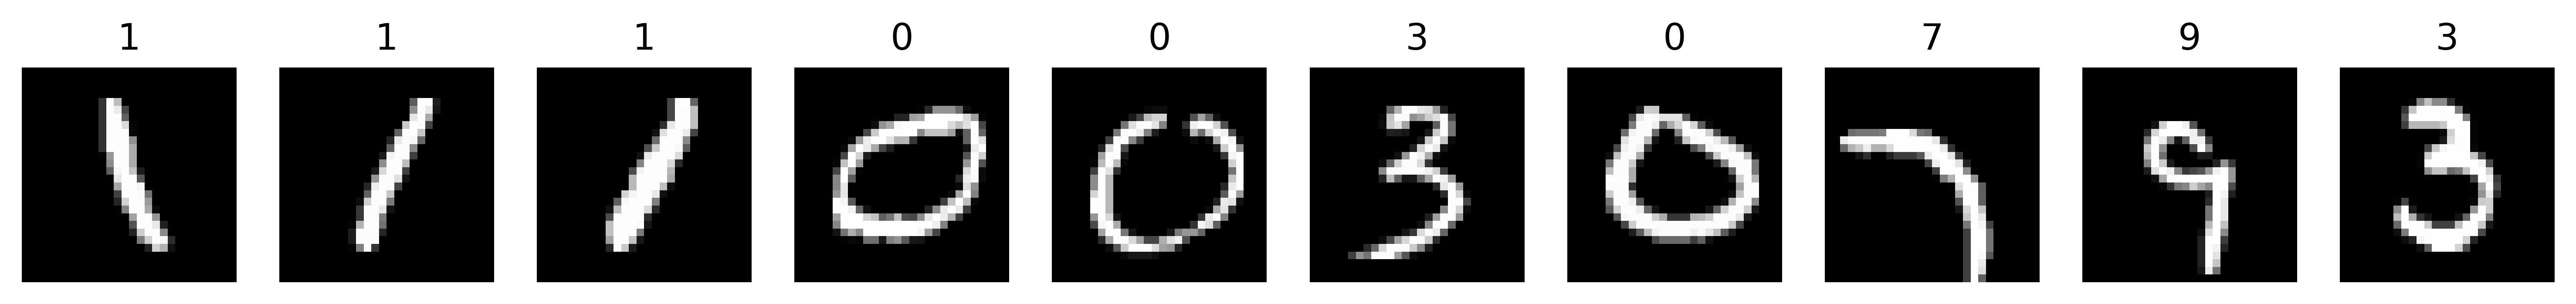

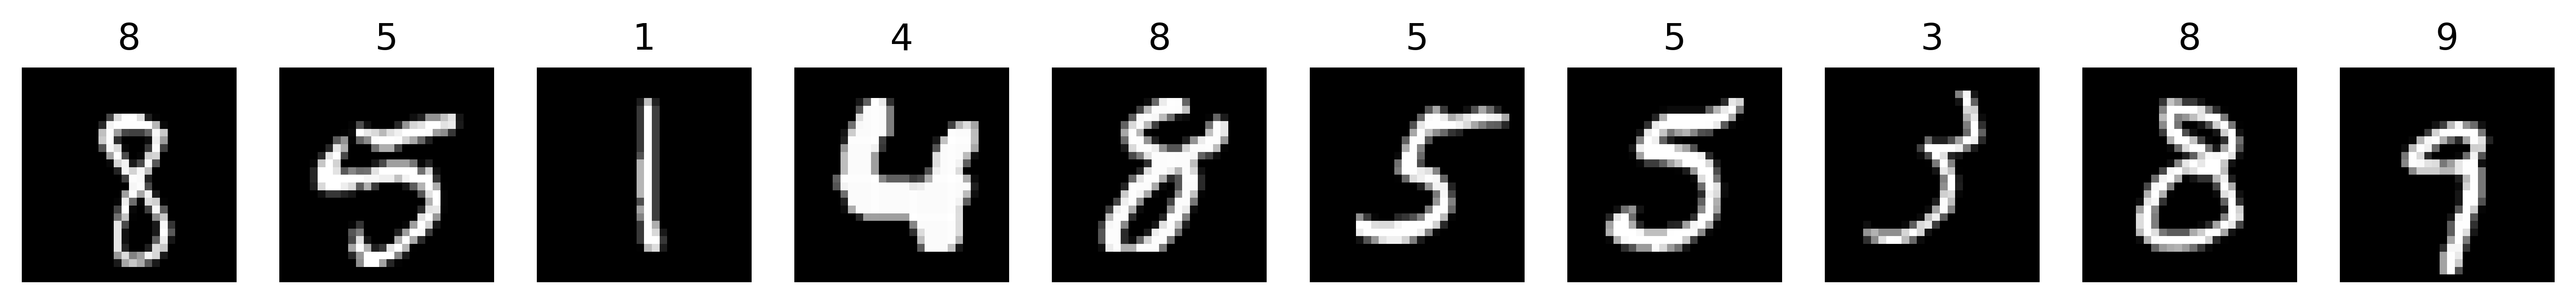

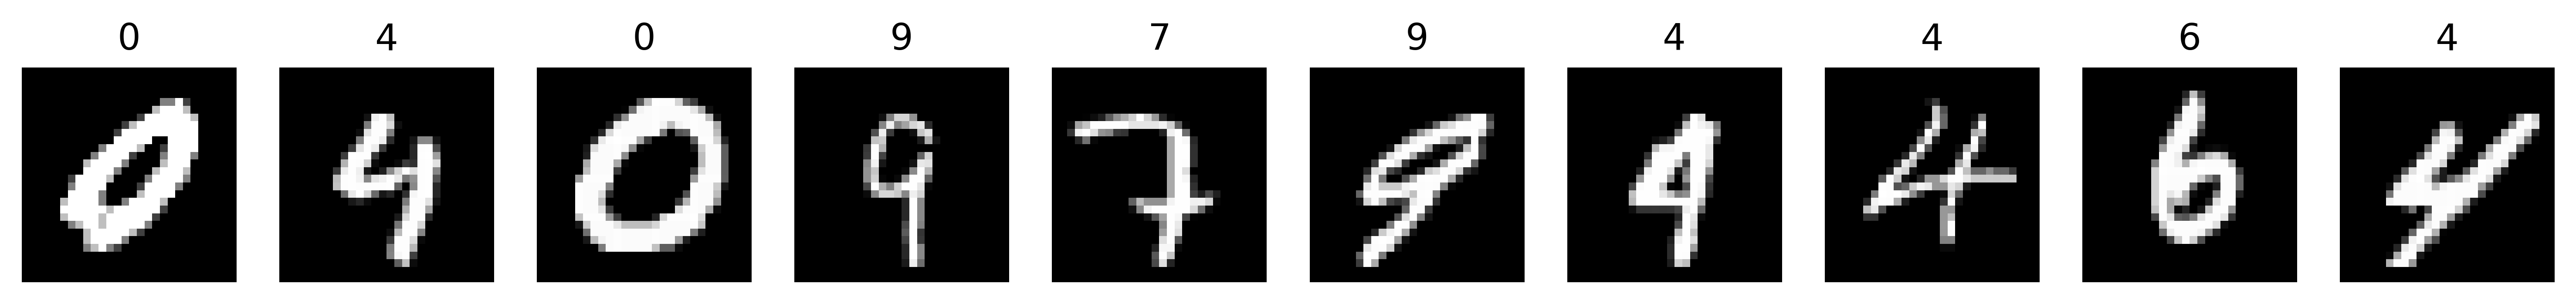

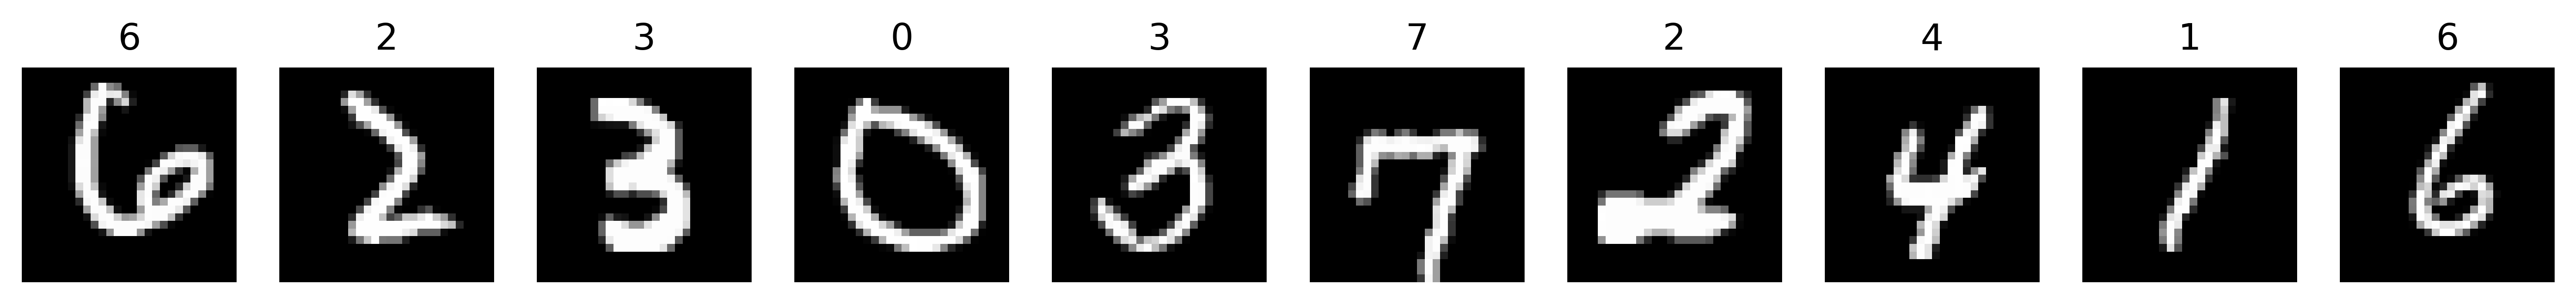

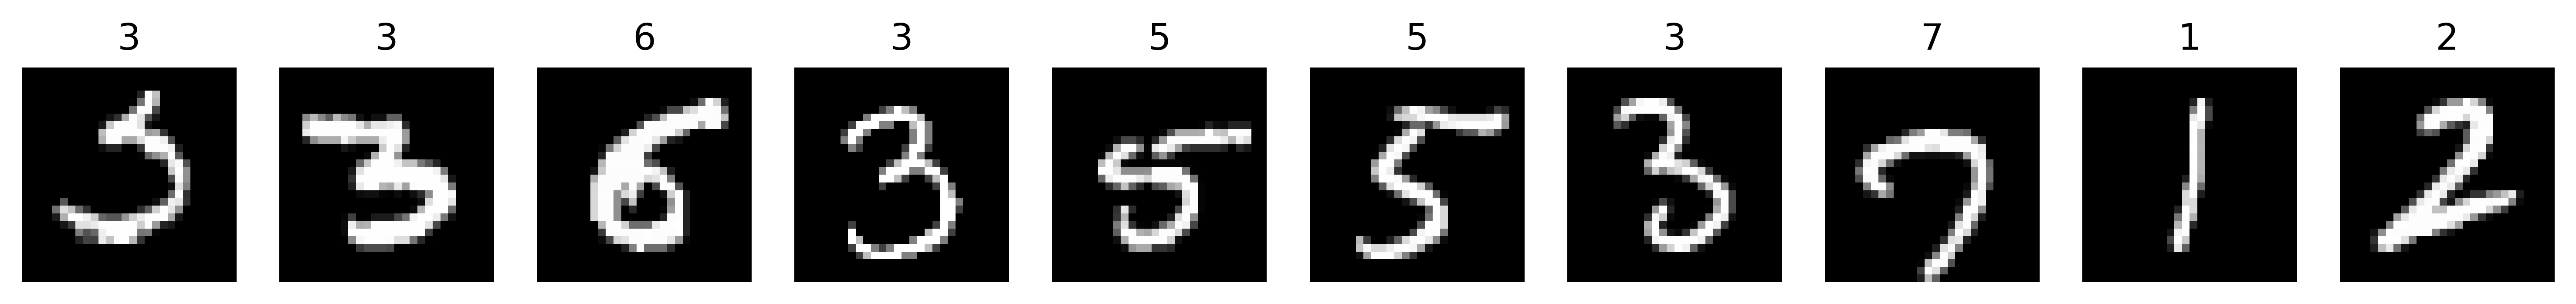

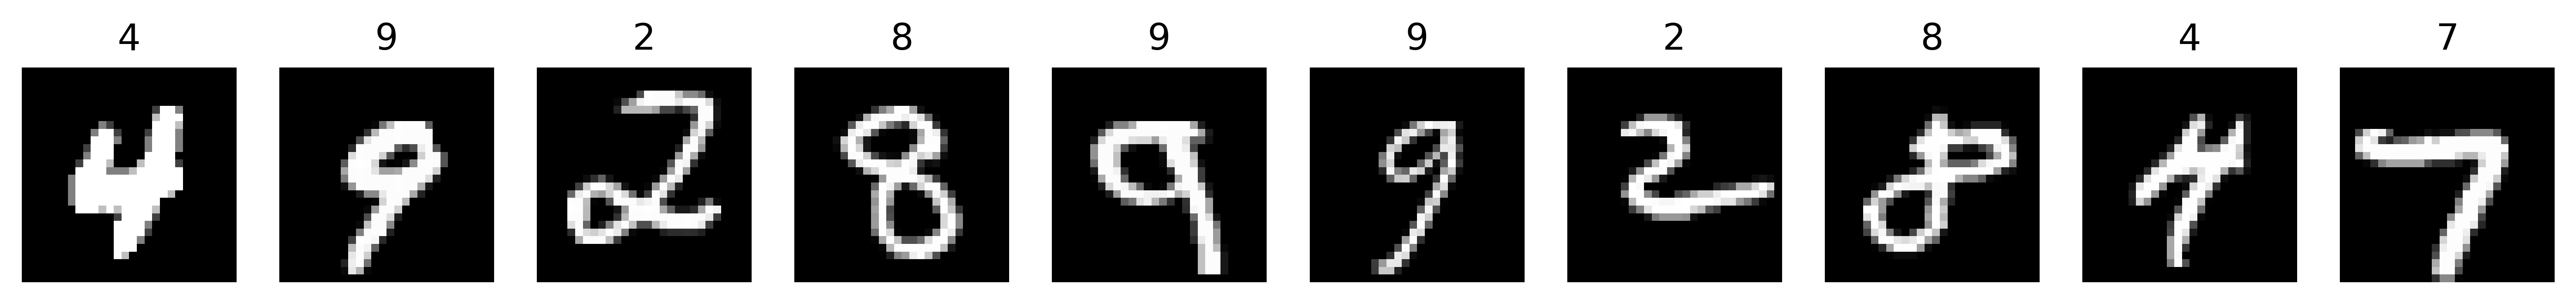

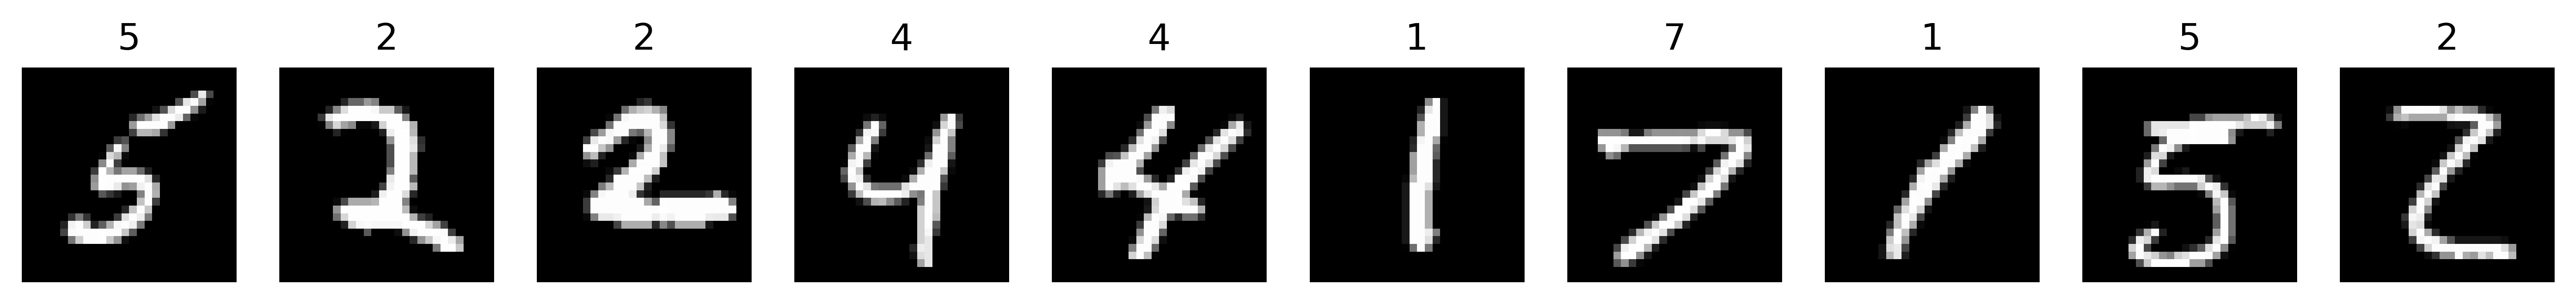

In [15]:
with torch.no_grad():
    for i, (input, label) in enumerate(test_loader, start=1):
        input = input.to(device)
        out, loss = model(input)
        
        fig, axis = plt.subplots(1, 10, figsize=(15, 5), dpi=500)
        for img, ax in zip(out, axis):
            idx = np.random.randint(0, len(train_set))
            img = train_set.data[idx]
            label = train_set.targets[idx]
            ax.imshow(img, cmap="gray")
            ax.set_title(label.item())
            ax.axis("off")
        # plt.show()
        plt.savefig(f'./generated_images/fig_{i}.png')

        if i == 10:
            break

In [51]:
latent_vectors = []
labels = []

with torch.no_grad():
    for images, targets in tqdm(test_loader):
        images = images.to(device)
        _, quantized, _ = model(images)
        quantized = quantized.reshape(-1, 64 * 3 * 3)
        latent_vectors.extend(quantized.cpu())
        labels.extend(targets)

100%|██████████| 1000/1000 [00:07<00:00, 142.71it/s]


In [52]:
latent_2d = TSNE(n_components=2).fit_transform(np.array(latent_vectors))

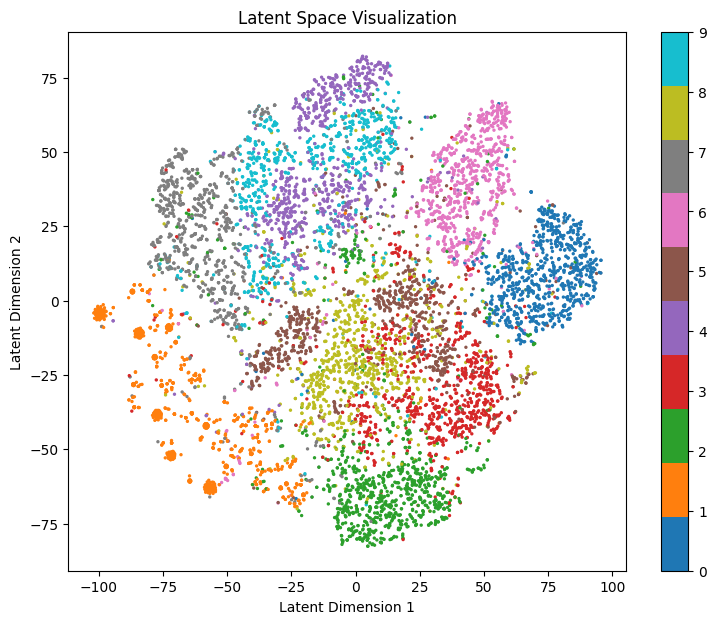

In [53]:
plt.figure(figsize=(9, 7))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', s=2)
plt.colorbar()
plt.title('Latent Space Visualization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()